# HW4P1: Language Modelling

Welcome to the final part 1 hw of this course. This is the only part 1 in which you have PyTorch training (Yay). You will be working on training language models and evaluating them on the task of prediction and generation.<br>
Note: A major change which we have made this semester is that we have made the model which you will be coding in this HW very similar to the Speller module from HW4P2.

# Get modules and datasets

In [ ]:
!pip install torchsummaryX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 10.7 MB/s eta 0:00:00


In [ ]:
# TODO: Import drive if you are using Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports

In [ ]:
import sys
sys.path.append("/content/gdrive/MyDrive/IDL/HW4/handout") # TODO: Add path to handout/

In [ ]:
%matplotlib inline

import torch

import os

import time
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from torchsummaryX import summary

import torch.nn.functional as F

# Importing necessary modules from hw4
from hw4.tests_hw4 import test_prediction, test_generation

from torchnlp.nn import LockedDropout

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)

%cd /content/gdrive/MyDrive/IDL/HW4/handout

Device:  cuda
/content/gdrive/MyDrive/IDL/HW4/handout


# Load datasets

In [ ]:

# Loading the vocabulary. Try printing and see
VOCAB       = np.load('dataset/vocab.npy')

# We have also included <sos> and <eos> in the vocabulary for you
# However in real life, you include it explicitly if not provided
SOS_TOKEN   = np.where(VOCAB == '<sos>')[0][0]
EOS_TOKEN   = np.where(VOCAB == '<eos>')[0][0]
NUM_WORDS   = len(VOCAB) - 2 # Actual number of words in vocabulary

print("Vocab length: ", len(VOCAB))
print(SOS_TOKEN)
print(EOS_TOKEN)
print(VOCAB)

Vocab length:  33280
33278
33279
['!' '"' '#' ... '～' '<sos>' '<eos>']


In [ ]:
# Loding the training dataset. Refer to write up section 2 to understand the structure
dataset     = np.load('dataset/wiki.train.npy', allow_pickle=True)

for i in range(len(dataset)):
    d = np.insert(dataset[i], 0, SOS_TOKEN)
    d = np.insert(d, len(d), EOS_TOKEN)
    dataset[i] = d.astype('int64')
# The dataset does not have <sos> and <eos> because they are just regular articles.
# TODO: Add <sos> and <eos> to every article in the dataset.
# Before doing do, try printing the dataset to see if they are words or integers.

In [ ]:


# Loading the fixtures for validation and test - prediction
fixtures_pred       = np.load('fixtures/prediction.npz')        # validation
fixtures_pred_test  = np.load('fixtures/prediction_test.npz')   # test

print("Validation shapes    : ", fixtures_pred['inp'].shape, fixtures_pred['out'].shape)
print("Test shapes          : ", fixtures_pred_test['inp'].shape)

Validation shapes    :  (128, 21) (128,)
Test shapes          :  (128, 21)


In [ ]:
print(fixtures_pred['out'][0])

72


In [ ]:
# Loading the fixtures for validation and test - generation
fixtures_gen        = np.load('fixtures/generation.npy')        # validation
fixtures_gen_test   = np.load('fixtures/generation_test.npy')   # test

print("Validation Gen Shapes    :", fixtures_gen.shape)
print("Test Gen Shapes          :", fixtures_gen_test.shape)

Validation Gen Shapes    : (32, 21)
Test Gen Shapes          : (128, 31)


In [ ]:
# Example Prediction Dev Input and Output
# Optional TODO: You can try printing a few samples from the validation set which has both inputs and outputs

#print(fixtures_gen)

# Custom DataLoader

In [ ]:
class DataLoaderForLanguageModeling(torch.utils.data.DataLoader): # Inherit from torch.utils.data.DataLoader
    """
        TODO: Define data loader logic here
    """
    # TODO: You can probably add more parameters as well. Eg. sequence length
    def __init__(self, dataset, batch_size, shuffle= True, drop_last= False, seq_len = 16):

        # If you remember, these are the standard things which you give while defining a dataloader.
        # Now you are just customizing your dataloader
        self.dataset    = dataset
        self.batch_size = batch_size
        self.shuffle    = shuffle
        self.drop_last  = drop_last
        self.seq_len = seq_len


        if self.shuffle:
            np.random.shuffle(self.dataset)

        article_list = np.concatenate(self.dataset)
        print("DATALEN: ", len(article_list))


        inputs = np.stack(article_list[idx: idx + self.seq_len] for idx in range(0, len(article_list) - self.seq_len, self.seq_len))
        targets = np.stack(article_list[idx + 1: idx + self.seq_len + 1] for idx in range(0, len(article_list) - self.seq_len, self.seq_len))


        rem = inputs.shape[0] % self.batch_size

        if self.drop_last:
            inputs = inputs[:-rem, :]
            targets = targets[:-rem, :]
        else:
            inputs = np.concatenate((inputs, np.zeros(shape = (self.batch_size - rem, self.seq_len))), axis = 0)
            targets = np.concatenate((targets, np.zeros(shape = (self.batch_size - rem, self.seq_len))), axis = 0)


        self.batched_input = inputs.reshape(-1, self.batch_size, self.seq_len)
        self.batched_target = targets.reshape(-1, self.batch_size, self.seq_len)

        print(self.batched_input.shape)
        print(self.batched_target.shape)



        self.num_batches = self.batched_input.shape[0]





    def __len__(self):
        # What output do you get when you print len(loader)? You get the number of batches
        # Your dataset has (579, ) articles and each article has a specified amount of words.
        # You concatenate the dataset and then batch parts of it according to the sequence length
        # TODO: return the number of batches
        # If you are using variable sequence_length, the length might not be fixed
        return self.num_batches

    def __iter__(self):
        # TODOs:
        # 1. Shuffle data if shuffle is True
        # 2. Concatenate articles and drop extra words
        # 3. Divide the concetenated dataset into inputs and targets. How do they vary?
        # 4. Reshape the inputs and targets into batches (think about the final shape)
        # 5. Loop though the batches and yield the input and target according to the sequence length

        #print(num_batches)
        batch_idx = 0


        start = 0

        while batch_idx < self.num_batches:
            #print(batch_idx)
            yield torch.tensor(self.batched_input[batch_idx]), torch.tensor(self.batched_target[batch_idx])
            batch_idx += 1




In [ ]:
# Some sanity checks

batch_size = 256

dl = DataLoaderForLanguageModeling(
    dataset     = dataset,
    batch_size  = 128,
    shuffle     = True,
    drop_last   = True
    # Input Extra parameters here if needed
)

inputs, targets = next(iter(dl))
print(inputs.shape, targets.shape)

print(len(dl))

for x, y in dl:
    print("x: ", [VOCAB[i] for i in x[0, :]])
    print("y: ", [VOCAB[i] for i in y[0, :]])
    break

DATALEN:  2076835


/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1014, 128, 16)
(1014, 128, 16)
torch.Size([128, 16]) torch.Size([128, 16])
1014
x:  ['<sos>', '=', 'St', 'Mary', "'s", 'Church', ',', 'Rhodogeidio', '=', '<eol>', 'St', 'Mary', "'s", 'Church', ',', 'Rhodogeidio']
y:  ['=', 'St', 'Mary', "'s", 'Church', ',', 'Rhodogeidio', '=', '<eol>', 'St', 'Mary', "'s", 'Church', ',', 'Rhodogeidio', 'is']


# LanguageModel

In [ ]:
LSTMConfig = {
    'num_layers': 2,
    'hidden_state': 128
}

In [ ]:
# Here comes the main portion of this HW.
# You can do this with a regular LSTM similar to HW3P2.
# However, using LSTMCells will make this Language model very similar to the decoder in HW4P2 and we recommend you use that for writing resuable code.

class LanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, n_embed, num_layers, hidden_size): # TODO: Add more parameters if you want
        super().__init__()
        self.vocab_size = vocab_size
        self.n_embed = n_embed
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # For all the layers which you will define, please read the documentation thoroughly before implementation

        self.token_embedding    = torch.nn.Embedding(vocab_size, n_embed) # TODO: Define a PyTorch embedding layer

        #print("embde weights: ", self.token_embedding.weight.data.shape)

        self.lstm_cells         = torch.nn.Sequential(
            torch.nn.LSTMCell(input_size = self.n_embed, hidden_size=self.hidden_size),
            torch.nn.LSTMCell(input_size = self.hidden_size, hidden_size=self.hidden_size)
            #torch.nn.LSTMCell(input_size = self.hidden_size, hidden_size=self.hidden_size) # TODO: Enter the parameters for the LSTMCells
            # You can add multiple LSTMCells too if you want
        )

        self.project = torch.nn.Linear(self.hidden_size, self.n_embed)

        self.token_probability  = torch.nn.Linear(self.hidden_size, vocab_size) # TODO: Define the parameters

        #print("prob weights: ", self.token_probability.weight.data.shape)

        #print("tying: " , self.token_probability.weight.data.shape)

        self.locked_dropout = LockedDropout(0.2)

        # Optional TODO: Weight Tying. You just need to make the embedding layer weights equal to the Linear layer weight.

        # So the basic pipline is:
        # word -> embedding -> lstm -> projection (linear) to get  probability distribution
        # And this is happening across all time steps

        self.token_probability.weight = self.token_embedding.weight

    def rnn_step(self, embedding, hidden_states_list):

        for i in range(len(self.lstm_cells)):
            # TODO: Forward pass through each LSTMCell
            # embedding ----> (B, n_embed)
            # update
            hidden_states_list[i] = self.lstm_cells[i].forward(embedding, hidden_states_list[i])
            embedding = hidden_states_list[i][0]

        return embedding, hidden_states_list

    def predict(self, x):
        # Refer to Section 1.3.1 to understand this function
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)

        hidden_state_ls = [None]*len(self.lstm_cells)

        with torch.inference_mode():
            # TODO: Pass the input sequence through the model
            x = self.token_embedding(x)

            # update

            for t in range(x.shape[1]): # LSTMCell is for just 1 timestep. Hence you need to loop through the total timesteps
                token_embedding_t           = x[:, t, :]
                rnn_out, hidden_state_ls = self.rnn_step(token_embedding_t, hidden_state_ls) #
                projection = self.project(rnn_out)
                token_prob_dist_t           = self.token_probability(projection) # TODO

            return token_prob_dist_t

    def generate(self, x, timesteps):
        # Refer to section 1.3.2 to understand this function
        # Important Note: We do not draw <eos> from the distribution unlike the writeup
        if not torch.is_tensor(x):
            x = torch.tensor(x).long().to(DEVICE)


        #print("GENERATE X shape: ", x.shape)

        # TODO: Pass the input sequence through the model
        # Obtain the probability distribution and hidden_states_list of the last timestep

        token_prob_dist, hidden_states_list     = self.forward(x)
        #print("MODEL OUTPUT: ", token_prob_dist.shape)

        # (B, vocab_size)
        prob_dist = F.softmax(token_prob_dist[:, -1, :], dim=-1)
        #print("PROB DIST: ", prob_dist.shape)

        # (B, 1)
        #next_token                              = torch.multinomial(prob_dist, num_samples = 1) # TODO: Draw the next predicted token from the probability distribution ()
        next_token = torch.argmax(prob_dist, dim = -1)
        #print("NEXT TOKEN SHAPE: ", next_token.shape)

        hidden_states_list      = [None]*len(self.lstm_cells) if hidden_states_list == None else hidden_states_list


        # [i] ----> (B)
        generated_sequence  = [next_token.squeeze()]

        with torch.inference_mode():
            for t in range(timesteps - 1): # Loop through the timesteps
                #   TODO: Pass the next_token and hidden_states_list through the model


                # (B, n_embed)
                token_embedding_t = self.token_embedding(next_token.squeeze())
                #print("token_embedding_t Loop: ", token_embedding_t.shape)


                rnn_out, hidden_state_list = self.rnn_step(token_embedding_t, hidden_states_list)

                projection = self.project(rnn_out)

                token_prob = self.token_probability(projection)

                #print("LOOP prob shape: ", token_prob.shape)

                # (B, vocab_size)
                prob_dist = F.softmax(token_prob, dim=-1)
                #print("Loop prob_dist: ", prob_dist.shape)

                # (B, 1)
                #next_token                              = torch.multinomial(prob_dist, num_samples = 1)
                next_token = torch.argmax(prob_dist, dim = -1)
                #print("LOOP NEXT TOKEN: ", next_token.shape)

                generated_sequence.append(next_token.squeeze())

            generated_sequence = torch.stack(generated_sequence, dim=1) # keep last timesteps generated words

            #print("Generated sequence: ", generated_sequence.shape)

        return generated_sequence

    # We are also having a hidden_states_list parameter because you need that in generation
    def forward(self, x, hidden_states_list= None): # train model
        # x (Batch, Seq_len)
        # Note: you dont have to return the sum of log probabilities according to Pseudocode 1 in the writeup
        # However, feel free to calculate and print it if you are curious

        #print("input shape: ", x.shape)

        batch_size, timesteps   = x.shape

        token_prob_distribution = [] # list which will contain probability distributions for all timesteps

        hidden_states_list      = [None]*len(self.lstm_cells) if hidden_states_list == None else hidden_states_list

        token_embeddings        = self.token_embedding(x) # (B, T, n_embed)

        #print("Token embeds shape: ", token_embeddings.shape)

        # When you get the embeddings of the input x, remember that you get it for all time steps.
        # Embedding is just a linear transformation so you can precompute it for all time steps.

        for t in range(timesteps): # LSTMCell is for just 1 timestep. Hence you need to loop through the total timesteps

            token_embedding_t           = token_embeddings[:, t, :]

            #print("Embedding size: ", token_embedding_t.shape)

            rnn_out, hidden_states_list = self.rnn_step(token_embedding_t, hidden_states_list) #

            b, hs = rnn_out.shape

            rnn_out = torch.reshape(rnn_out, (1, b, hs))

            rnn_out = self.locked_dropout(rnn_out)

            #print("LSTM output shape: ", rnn_out.shape) #(B, hidden_size)

            projection = self.project(rnn_out)

            projection = projection.squeeze()


            token_prob_dist_t           = self.token_probability(projection) # TODO

            token_prob_distribution.append(token_prob_dist_t)
            #print("tok_prob_dist shape: ", token_prob_dist_t.shape)

        token_prob_distribution = torch.stack(token_prob_distribution, dim=1) # TODO: Stack along the timesteps dimension
        #print("prob_dist shape: ", token_prob_distribution.shape)

        return token_prob_distribution, hidden_states_list

# Trainer Class

In [ ]:
#from torch.nn.parallel.data_parallel import device
# Unlike all the P2s, we are using a Trainer class for this HW.
# Many researchers also use classes like this for training. You may have encountered them in your project as well.
# You dont have to complete everything in this class, you only need to complete the train function.
# However, its good to go through the code and see what it does.

class Trainer:
    def __init__(self, model, loader, optimizer, criterion, scheduler=None, max_epochs= 1, run_id= 'exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model      = model
        self.loader     = loader
        self.optimizer  = optimizer
        self.criterion  = criterion

        self.train_losses           = []
        self.val_losses             = []
        self.predictions            = []
        self.predictions_test       = []
        self.generated_logits       = []
        self.generated              = []
        self.generated_logits_test  = []
        self.generated_test         = []
        self.epochs                 = 0
        self.max_epochs             = max_epochs
        self.run_id                 = run_id


    def calculate_loss(self, out, target):
        # output: (B, T, Vocab_size) - probability distributions
        # target: (B, T)
        # Read the documentation of CrossEntropyLoss and try to understand how it takes inputs

        # Tip: If your target is of shape (B, T) it means that you have B batches with T words.
        # Tip: What is the total number of words in this batch?
        # Tip: Crossentropy calculates the loss between a label and its probability distribution.

        B, T, vocab_size = out.shape

        out     = out.view(B*T, vocab_size) # TODO
        targets = target.view(B*T) # TODO
        loss    = self.criterion(out, targets)

        return loss


    def train(self):

        self.model.train() # set to training mode
        self.model.to(DEVICE)
        epoch_loss  = 0
        num_batches = 0
        scaler = torch.cuda.amp.GradScaler()
        total_loss = 0


        batch_bar = tqdm(total=len(self.loader), dynamic_ncols=True, leave=False, position=0, desc='Train')



        for batch_num, (inputs, targets) in enumerate(tqdm(self.loader)):
            self.optimizer.zero_grad()
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)

            with torch.cuda.amp.autocast():
                token_prob_dist, hidden_state_list = model(inputs)

                loss = self.calculate_loss(token_prob_dist, targets)

            #loss = loss.item()
            total_loss += loss.item()

            batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (batch_num + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))


            batch_bar.update() # Update tqdm bar



            scaler.scale(loss).backward() # This is a replacement for loss.backward()
            scaler.step(optimizer) # This is a replacement for optimizer.step()
            scaler.update()

            del inputs, targets, loss
            torch.cuda.empty_cache()


            # TODO: Complete the loop. You should be able to complete this without any helper comments after 3 HWs
            # Tip: Mixed precision training
            # For loss calculation, use the calculate_loss function. You need to complete it before using.


        epoch_loss = total_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN] \tEpoch [%d/%d] \tLoss: %.4f \tLr: %.6f'
                      % (self.epochs, self.max_epochs, epoch_loss, self.optimizer.param_groups[0]['lr']))
        self.train_losses.append(epoch_loss)
        batch_bar.close() # You need this to close the tqdm bar



    def test(self): # Don't change this function

        self.model.eval() # set to eval mode
        predictions     = model.predict(fixtures_pred['inp']).detach().cpu().numpy() # get predictions
        self.predictions.append(predictions)

        generated_logits        = model.generate(fixtures_gen, 10).detach().cpu().numpy() # generated predictions for 10 words
        generated_logits_test   = model.generate(fixtures_gen_test, 10).detach().cpu().numpy()

        nll             = test_prediction(predictions, fixtures_pred['out'])
        generated       = test_generation(fixtures_gen, generated_logits, VOCAB)
        generated_test  = test_generation(fixtures_gen_test, generated_logits_test, VOCAB)
        self.val_losses.append(nll)

        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)

        # generate predictions for test data
        predictions_test = model.predict(fixtures_pred_test['inp']).detach().cpu().numpy() # get predictions
        self.predictions_test.append(predictions_test)

        print('[VAL] \tEpoch [%d/%d] \tLoss: %.4f'
                      % (self.epochs, self.max_epochs, nll))
        return nll


    def save(self): # Don't change this function

        model_path = os.path.join('hw4/experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()}, model_path)
        np.save(os.path.join('hw4/experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('hw4/experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])

        with open(os.path.join('hw4/experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])

        with open(os.path.join('hw4/experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])

# Experiment setup

In [ ]:
# TODO: define other hyperparameters here

configs = dict(
    batch_size  = 64,
    num_epochs  = 20, # 10 or 20 epochs should be enough given the model is good
    init_lr     = 2e-3 # TODO
)

vocab_size = len(VOCAB)
n_embed = 64


In [ ]:
loader      = DataLoaderForLanguageModeling(
    dataset     = dataset,
    batch_size  = configs['batch_size'],
    shuffle     = True,
    drop_last   = True
) # TODO: Define the dataloader



print("Batch size: ", configs['batch_size'])
inputs, targets = next(iter(loader))
print(inputs, targets)

print(targets.dtype)
print("Train dataset samples = {}, batches = {}".format(dataset.__len__(), len(loader)))
#print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

DATALEN:  2076835
(2028, 64, 16)
(2028, 64, 16)
Batch size:  64
tensor([[33278,  1420,  7132,  ..., 25370,    76, 29345],
        [ 7132,  2806,    72,  ..., 30017, 16802,  1822],
        [28891, 16004,  9887,  ..., 26510, 26104, 25821],
        ...,
        [32846, 28296, 22968,  ..., 17027, 19997, 25821],
        [31353, 29762, 18162,  ...,  1424, 29691,    76],
        [32885, 31353,   222,  ...,     1, 12497,     1]]) tensor([[ 1420,  7132,  2806,  ...,    76, 29345,  7132],
        [ 2806,    72,   814,  ..., 16802,  1822, 28891],
        [16004,  9887,    79,  ..., 26104, 25821, 31353],
        ...,
        [28296, 22968, 31353,  ..., 19997, 25821, 31353],
        [29762, 18162, 14658,  ..., 29691,    76, 32885],
        [31353,   222,  1424,  ..., 12497,     1,  1415]])
torch.int64
Train dataset samples = 579, batches = 2028


In [ ]:

'''model       = LanguageModel(vocab_size=vocab_size, n_embed = 32, num_layers = 2, hidden_size = 128).to(DEVICE)
summary(model, inputs.to(DEVICE))'''

'model       = LanguageModel(vocab_size=vocab_size, n_embed = 32, num_layers = 2, hidden_size = 128).to(DEVICE)\nsummary(model, inputs.to(DEVICE))'

In [ ]:


model       = LanguageModel(vocab_size=vocab_size, n_embed = 64, num_layers = 2, hidden_size = 128).to(DEVICE)

loader      = DataLoaderForLanguageModeling(
    dataset     = dataset,
    batch_size  = configs['batch_size'],
    shuffle     = True,
    drop_last   = True
) # TODO: Define the dataloader

criterion   = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer   = torch.optim.AdamW(model.parameters(), lr=configs['init_lr'], weight_decay = 0.02) # TODO: Define the optimizer. Adam/AdamW usually works good for this HW

# Optional TODO: Use a scheduler if you want

scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=1) #TODO


print(model)
summary(model, x = inputs.to(DEVICE))

DATALEN:  2076835
(2028, 64, 16)
(2028, 64, 16)
LanguageModel(
  (token_embedding): Embedding(33280, 64)
  (lstm_cells): Sequential(
    (0): LSTMCell(64, 128)
    (1): LSTMCell(128, 128)
  )
  (project): Linear(in_features=128, out_features=64, bias=True)
  (token_probability): Linear(in_features=128, out_features=33280, bias=True)
  (locked_dropout): LockedDropout(p=0.2)
)
                     Kernel Shape  Output Shape    Params Mult-Adds
Layer                                                              
0_token_embedding     [64, 33280]  [64, 16, 64]  2.12992M  2.12992M
1_locked_dropout                -  [1, 64, 128]         -         -
2_project               [128, 64]   [1, 64, 64]    8.256k    8.192k
3_token_probability   [64, 33280]   [64, 33280]   2.1632M  2.12992M
4_locked_dropout                -  [1, 64, 128]         -         -
5_project               [128, 64]   [1, 64, 64]         -    8.192k
6_token_probability   [64, 33280]   [64, 33280]         -  2.12992M
7_locked_d

/usr/local/lib/python3.9/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_token_embedding,"[64, 33280]","[64, 16, 64]",2129920.0,2129920.0
1_locked_dropout,-,"[1, 64, 128]",NaN,NaN
2_project,"[128, 64]","[1, 64, 64]",8256.0,8192.0
3_token_probability,"[64, 33280]","[64, 33280]",2163200.0,2129920.0
4_locked_dropout,-,"[1, 64, 128]",NaN,NaN
5_project,"[128, 64]","[1, 64, 64]",NaN,8192.0
6_token_probability,"[64, 33280]","[64, 33280]",NaN,2129920.0
7_locked_dropout,-,"[1, 64, 128]",NaN,NaN
8_project,"[128, 64]","[1, 64, 64]",NaN,8192.0


In [ ]:
# Dont change this cell

run_id = str(int(time.time()))
if not os.path.exists('./hw4/experiments'):
    os.mkdir('./hw4/experiments')
os.mkdir('./hw4/experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./hw4/experiments/%s" % run_id)

# The object of the Trainer class takes in everything
trainer = Trainer(
    model       = model,
    loader      = loader,

    optimizer   = optimizer,
    criterion   = criterion,

    max_epochs  = configs['num_epochs'],
    run_id      = run_id
)

Saving models, predictions, and generated words to ./hw4/experiments/1681953158


In [ ]:
# Run the experiments loop.
# Each epoch wont take more than 2-3min. If its taking more time, it might be due to (but not limited to) the following:
#   * You might be overlapping batches
#       Eg. Input: "I had biryani for lunch today" and sequence length = 3,
#           --> "I had biryani", "for lunch today" are ideal examples for inputs
#           --> "I had biryani", "had biryani for", "biryani for lunch", ... is just redundant info :')
#   * Your length calculation in the dataloader might be wrong
# If you haven't had biryani, try it :D

%%time
best_nll = 1e30
for epoch in range(configs['num_epochs']):
    trainer.train()
    nll = trainer.test()
    scheduler.step(nll)
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch+1)+" with NLL: "+ str(best_nll))
        trainer.save()

Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [1/20] 	Loss: 7.2369 	Lr: 0.002000
[VAL] 	Epoch [1/20] 	Loss: 5.5659
Saving model, predictions and generated output for epoch 1 with NLL: 5.5659246


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [2/20] 	Loss: 6.7012 	Lr: 0.002000
[VAL] 	Epoch [2/20] 	Loss: 5.2995
Saving model, predictions and generated output for epoch 2 with NLL: 5.299547


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [3/20] 	Loss: 6.5013 	Lr: 0.002000
[VAL] 	Epoch [3/20] 	Loss: 5.1693
Saving model, predictions and generated output for epoch 3 with NLL: 5.1693244


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [4/20] 	Loss: 6.3789 	Lr: 0.002000
[VAL] 	Epoch [4/20] 	Loss: 5.0613
Saving model, predictions and generated output for epoch 4 with NLL: 5.061322


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [5/20] 	Loss: 6.2901 	Lr: 0.002000
[VAL] 	Epoch [5/20] 	Loss: 4.9999
Saving model, predictions and generated output for epoch 5 with NLL: 4.9998994


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [6/20] 	Loss: 6.2174 	Lr: 0.002000
[VAL] 	Epoch [6/20] 	Loss: 4.9389
Saving model, predictions and generated output for epoch 6 with NLL: 4.9389396


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [7/20] 	Loss: 6.1548 	Lr: 0.002000
[VAL] 	Epoch [7/20] 	Loss: 4.8884
Saving model, predictions and generated output for epoch 7 with NLL: 4.888412


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [8/20] 	Loss: 6.0983 	Lr: 0.002000
[VAL] 	Epoch [8/20] 	Loss: 4.8572
Saving model, predictions and generated output for epoch 8 with NLL: 4.8572407


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [9/20] 	Loss: 6.0479 	Lr: 0.002000
[VAL] 	Epoch [9/20] 	Loss: 4.8152
Saving model, predictions and generated output for epoch 9 with NLL: 4.815209


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [10/20] 	Loss: 6.0019 	Lr: 0.002000
[VAL] 	Epoch [10/20] 	Loss: 4.7574
Saving model, predictions and generated output for epoch 10 with NLL: 4.7573776


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [11/20] 	Loss: 5.9602 	Lr: 0.002000
[VAL] 	Epoch [11/20] 	Loss: 4.7398
Saving model, predictions and generated output for epoch 11 with NLL: 4.7398214


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [12/20] 	Loss: 5.9231 	Lr: 0.002000
[VAL] 	Epoch [12/20] 	Loss: 4.7338
Saving model, predictions and generated output for epoch 12 with NLL: 4.733836


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [13/20] 	Loss: 5.8902 	Lr: 0.002000
[VAL] 	Epoch [13/20] 	Loss: 4.7171
Saving model, predictions and generated output for epoch 13 with NLL: 4.717101


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [14/20] 	Loss: 5.8602 	Lr: 0.002000
[VAL] 	Epoch [14/20] 	Loss: 4.6856
Saving model, predictions and generated output for epoch 14 with NLL: 4.685558


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [15/20] 	Loss: 5.8338 	Lr: 0.002000
[VAL] 	Epoch [15/20] 	Loss: 4.6753
Saving model, predictions and generated output for epoch 15 with NLL: 4.675254


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [16/20] 	Loss: 5.8102 	Lr: 0.002000
[VAL] 	Epoch [16/20] 	Loss: 4.6888


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [17/20] 	Loss: 5.7893 	Lr: 0.002000
[VAL] 	Epoch [17/20] 	Loss: 4.7107


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [18/20] 	Loss: 5.7297 	Lr: 0.001400
[VAL] 	Epoch [18/20] 	Loss: 4.7152


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [19/20] 	Loss: 5.7050 	Lr: 0.001400
[VAL] 	Epoch [19/20] 	Loss: 4.7086


Train:   0%|          | 0/2028 [00:00<?, ?it/s]

  0%|          | 0/2028 [00:00<?, ?it/s]

[TRAIN] 	Epoch [20/20] 	Loss: 5.6600 	Lr: 0.000980
[VAL] 	Epoch [20/20] 	Loss: 4.7181
CPU times: user 18min 49s, sys: 7min 40s, total: 26min 29s
Wall time: 25min 51s


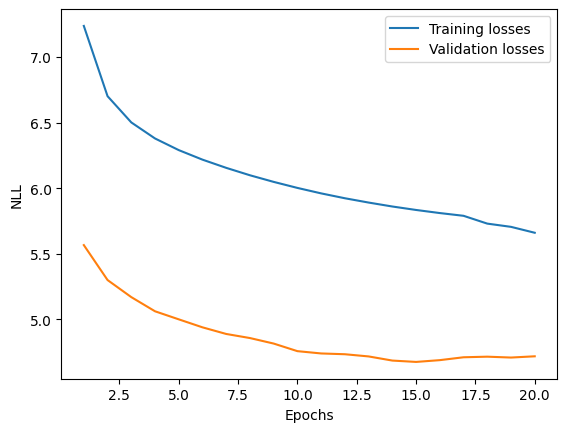

In [ ]:
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses[0:20], label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

# Create handin

In [ ]:
# TODO: Generate the handin to submit to autolab
!make runid=1681953158 epoch=15

cp hw4/experiments/1681953158/predictions-test-15.npy predictions.npy
cp hw4/experiments/1681953158/generated-15.txt generated.txt
cp hw4/experiments/1681953158/generated_logits-test-15.npy generated_logits.npy
cp hw4/hw4p1.ipynb training.ipynb
tar -cvf handin.tar training.ipynb predictions.npy generated.txt generated_logits.npy
training.ipynb
predictions.npy
generated.txt
generated_logits.npy
rm -f generated.txt predictions.npy training.ipynb generated_logits.npy
